In [1]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git' -q
!pip install -q roboflow supervision
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3h2iija2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3h2iija2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pytoolconfig 1.2.5 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.


In [3]:
import torch
from segment_anything import sam_model_registry
import matplotlib.pyplot as plt
import cv2
from segment_anything import SamAutomaticMaskGenerator
import supervision as sv
import cv2
import numpy as np
from segment_anything import SamPredictor


In [37]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [3]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam = sam_model_registry[MODEL_TYPE](checkpoint=sam_checkpoint)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [5]:
mask_generator = SamAutomaticMaskGenerator(sam)
IMAGE_PATH = "/kaggle/input/images-sam-test/dog.jpg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)

In [6]:
mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(result)
annotated_image = mask_annotator.annotate(image_bgr, detections)

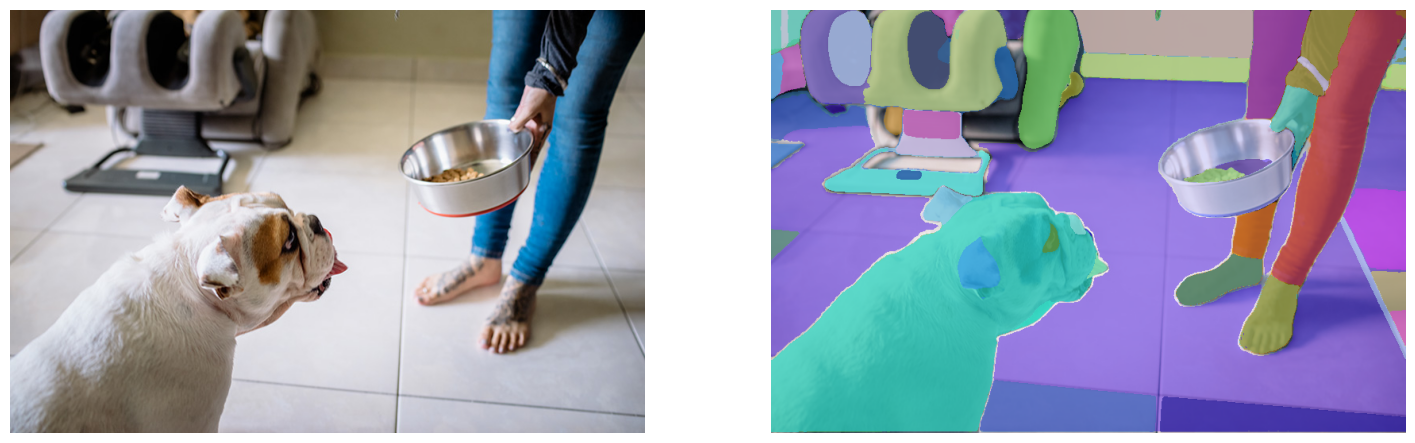

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
axs[0].imshow(image_rgb)
axs[1].imshow(annotated_image)
# show_anns(masks, axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()
# plt.imshow()

In [82]:
mask_predictor = SamPredictor(sam)

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
mask_predictor.set_image(image_rgb)

box = np.array([2, 210, 429, 530])
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [83]:
masks.shape

(3, 534, 800)

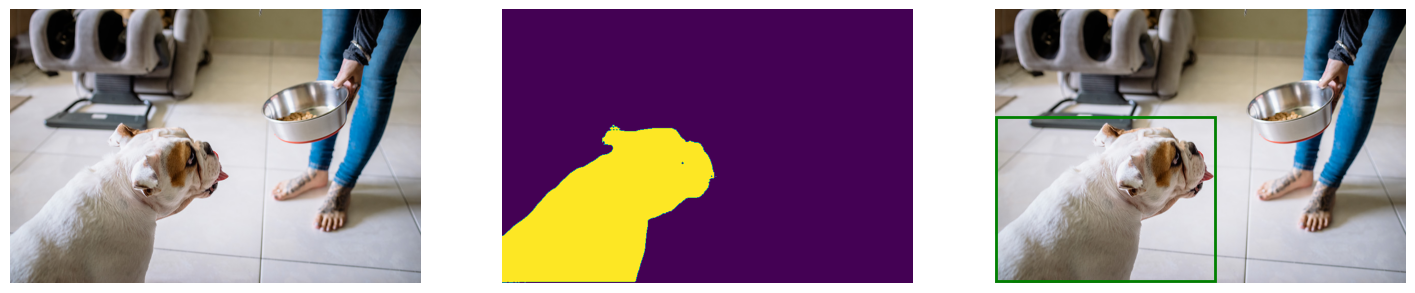

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(18, 7))
axs[0].imshow(image_rgb)
axs[1].imshow(masks[0])
axs[2].imshow(image_rgb)
show_box(box, plt.gca())
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
plt.show()

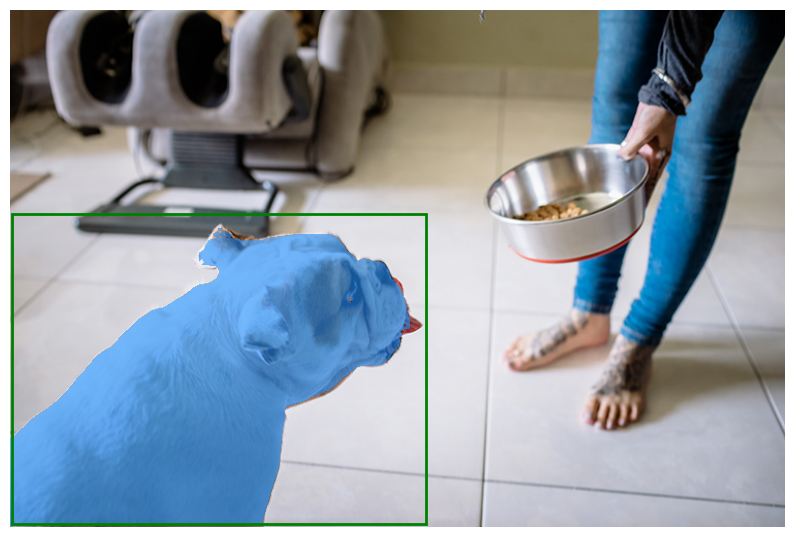

In [97]:
plt.figure(figsize=(10, 7))
plt.imshow(image_rgb)
show_mask(masks[0], plt.gca())
show_box(box, plt.gca())
axs[0].imshow(image_rgb)
axs[1].imshow(annotated_image)
axs[0].axis('off')
axs[1].axis('off')
plt.axis('off')
plt.show()

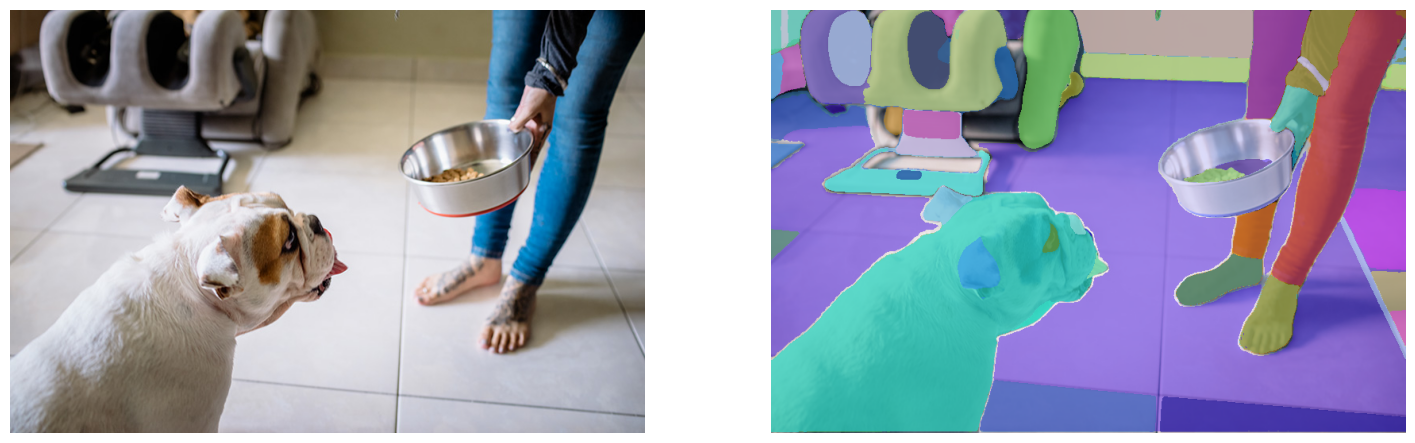

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
axs[0].imshow(image_rgb)
axs[1].imshow(annotated_image)
# show_anns(masks, axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()